# Práctica IV
## Nombre: Incluye tu nombre y apellidos

Valor de la práctica en el curso 2 puntos. Calificación de la práctica sobre 10.

Usaremos los siguiente módulos y librerías y el path a las imágenes

In [2]:
%matplotlib inline 
import numpy as np
import scipy.fft
import cv2 as cv

from skimage.io import imread, imsave   
from skimage.color import rgb2gray

from scipy import signal
import scipy.fftpack

from PIL import Image, ImageEnhance, ImageFilter

import matplotlib.pyplot as plt

# incluye aquí los módulos adicionales que necesites

In [3]:
IMPATH="../imagenes curso/"

## Primer ejercicio (4 puntos)

La imagen del cameraman ha sido observada por una cámara que introduce patrones de barras verticales. 

255 0


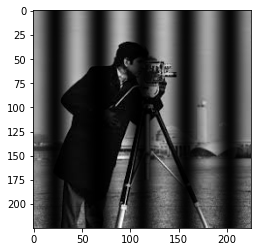

In [4]:
noisy_image = imread(IMPATH+'cameraman_field.png')
(dim_y,dim_x)=noisy_image.shape
print(noisy_image.max(),noisy_image.min())
_=plt.imshow(noisy_image,cmap='gray')

El modelo de observación es

    noisy_image=original_image*field
    
donde la imagen field es de la forma

    for x in range(dim_x):
        field[:,x]=(np.cos(2*np.pi*N*x/dim_y)+1.1)/2.1

donde dim_x es el número de columnas de la imagen original y N un número desconocido.

**1.1  (2 puntos)**

Estima N y reconstruye la imagen original

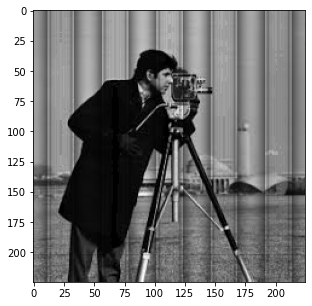

In [23]:

#Calculo el inverso de field
N=5 # Ya que hay 5 bandas en la imagen
inversed_field = np.empty_like(noisy_image)

for x in range(dim_x):
    fvalue = (np.cos(2*np.pi*N*x/dim_y)+1.1)/2.1
    inv_fvalue = fvalue**(-1)
    inversed_field[:,x]=inv_fvalue

reb_image = noisy_image*inversed_field

plt.figure(figsize=(5,5))
_=plt.imshow(reb_image,cmap='gray')

**1.2 (2 puntos)**

Si has hecho bien el ejercicio 1.2 habrás obtenido una estimación de la imagen original similar a la siguiente:

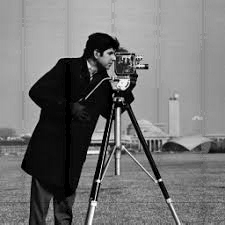

Implementa un método que elimine los artificios que todavía quedan en la imagen reconstruida

(-0.5, 224.5, 224.5, -0.5)

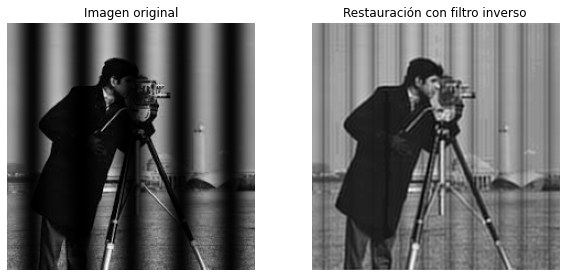

In [27]:
#Aplico el filtro inverso
dim=reb_image.shape
    # núcleo de emborronamiento
kernel = np.outer(signal.gaussian(dim[0], 3),signal.gaussian(dim[1], 3))
kernel=kernel/kernel.sum()

    # Fourier de la imagen original y el núcleo (con shift)
im_fft= np.fft.fft2(reb_image)
kernel_fft = np.fft.fft2(np.fft.ifftshift(kernel)) 

    #TDF imagen borrosa
im_blur = np.fft.ifft2(im_fft*kernel_fft).real

epsilon = 10**-6
im_blur_fft = np.fft.fft2(im_blur)
inv_kernel_fft = 1.0 / (epsilon + kernel_fft) 

im_restored_fft = im_blur_fft*inv_kernel_fft
im_restored = np.fft.ifft2(im_restored_fft).real

plt.figure(figsize=(10,10))
plt.gray()
plt.subplot(221), plt.imshow(noisy_image), plt.title('Imagen original'), plt.axis('off')
plt.subplot(222), plt.imshow(im_restored), plt.title('Restauración con filtro inverso')
plt.axis('off')


## Segundo ejercicio (4 Puntos)

Elimina el ruido de la imagen siguiente

Máximo y Mínimo:
 255.0 0.0
Shape:  (474, 630)


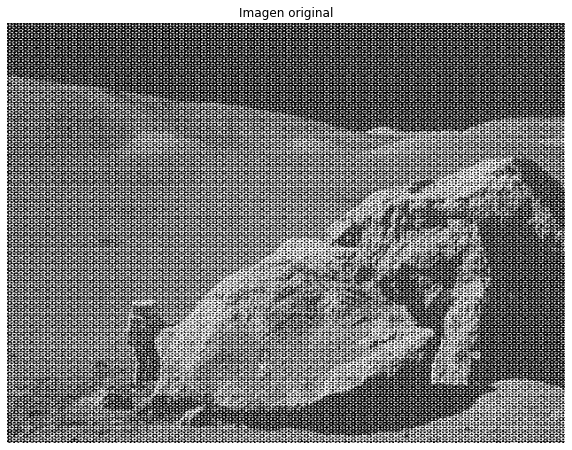

In [113]:
im = imread(IMPATH+'moonlanding.png').astype(float)
print("Máximo y Mínimo:\n", im.max(),im.min())
print("Shape: ",im.shape)
plt.figure(figsize=(10,10))
plt.imshow(im, plt.cm.gray)
plt.axis('off') 
_=plt.title('Imagen original')

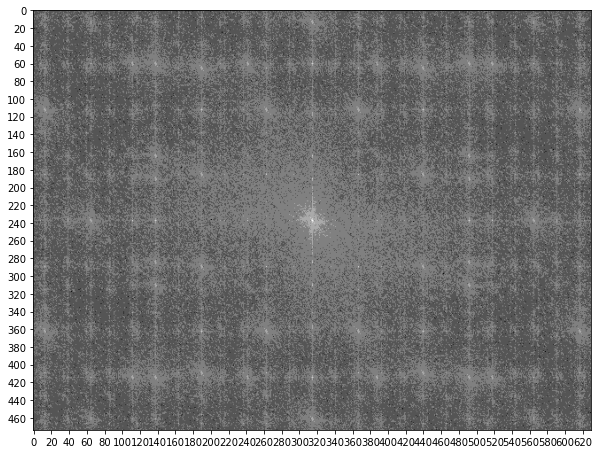

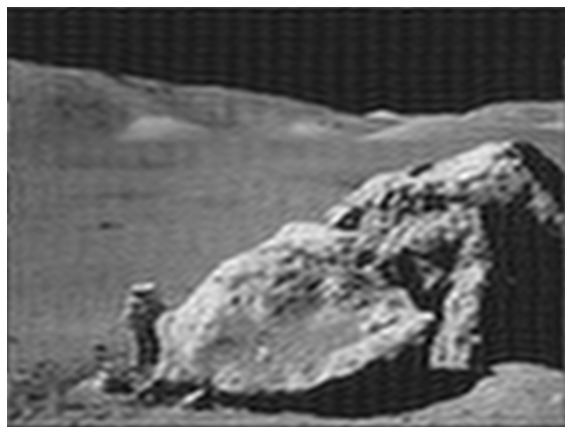

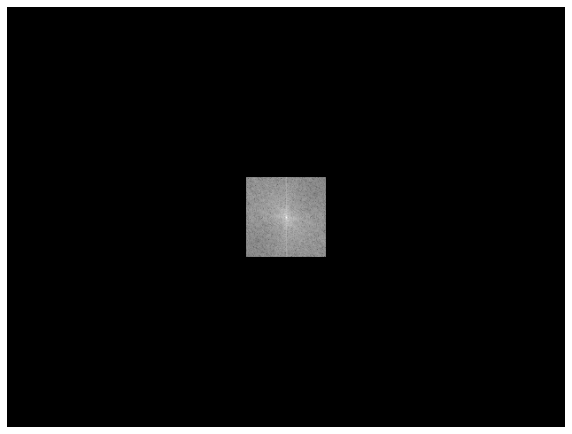

In [122]:
F1 = scipy.fft.fft2((im).astype(float))
F2 = scipy.fft.fftshift(F1)

w,h = im.shape

plt.figure(figsize=(10,10)), 
pos=plt.imshow(10*np.log10(1 + np.abs(F2)).astype(int),cmap=plt.cm.gray)
plt.xticks(range(0,h,20))
plt.yticks(range(0,w,20))
plt.show()

half_w, half_h = int(w/2), int(h/2)

freq2_low = np.copy(F2)
lx=45
ly=45
freq2_low[half_w-lx:half_w+lx,half_h-ly:half_h+ly] = 0 # bloquea las frecuencias bajas
F2 -= freq2_low # nos quedamos con el bloque central de frecuencias bajas

im1 = scipy.fft.ifft2(scipy.fft.ifftshift(F2)).real

plt.figure(figsize=(10,10))
plt.imshow(im1, cmap='gray')
plt.axis('off')


plt.figure(figsize=(10,10))
plt.imshow( (10*np.log10( 1 + abs(F2))).astype(int),cmap='gray')
_=plt.axis('off')


Lo mejor sería usar un filtro de rechazo de banda ya que no se perdería tanta información de la imagen original. Sin embargo, tras muchos intentos no daba con un patrón relativamente sencillo por lo que opté por implementar un filtro de paso bajo, obteniendo un resultado muy similar a los que obtenía con el filtro de rechazo de banda. 

## Tercer ejercicio (2 puntos)

El tercer ejercicio está dedicado al filtro de Wiener. 

Recuerda que este filtro utilizaba el modelo espacial

\begin{equation*}
g(x,y)=h(x,y)*f(x,y)+\mbox{ruido}(x,y)
\end{equation*}

donde no conocíamos el ruido, sólo la imagen observada $g(x,y)$ y el emborronamiento $h(x,y)$.

Vimos en teoría que el filtro de Wiener, en su versión simplificada, estima la transformada de Fourier de la imagen original utilizando
\begin{equation*}
\hat F(u,v)=\frac{H^*(u,v)}{\alpha+ H(u,v)H^*(u,v)}G(u,v)
\end{equation*}

Si ahora llamamos $\beta=\frac{1}{1+\alpha}$ tenemos

\begin{equation*}
\hat F(u,v)=\frac{\beta H^*(u,v)}{(1-\beta)\times 1+ \beta H(u,v)H^*(u,v)}G(u,v)
\end{equation*}

donde $\hat F(u,v)$ es la estimación de la transformada de Fourier de la imagen original que produce el filtro de Wiener simplificado y $\beta\in (0,1)$.

Vamos a comenzar generando nuestra imagen borrosa y ruidosa

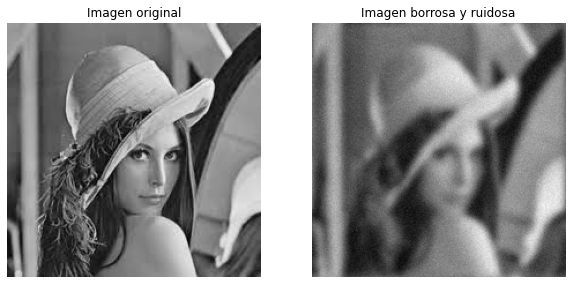

In [52]:
im = rgb2gray(imread(IMPATH+'lena.jpg'))
dim=im.shape

# nuestra función de emborronamiento
kernel = np.outer(signal.gaussian(dim[0], 3),signal.gaussian(dim[1], 3))
kernel=kernel/kernel.sum()

# Fourier de la imagen original y del emborronamiento
im_fft = np.fft.fft2(im)
kernel_fft = np.fft.fft2(np.fft.ifftshift(kernel)) 

# introducción de ruido

prop=0.1
np.random.seed(0)
noise=prop* im.std() * np.random.standard_normal(dim)


im_blur_noise_fft = im_fft*kernel_fft +np.fft.fft2(noise)
im_blur_noise = np.fft.ifft2(im_blur_noise_fft).real

plt.figure(figsize=(10,10))
plt.gray()
plt.subplot(121), plt.imshow(im), plt.title('Imagen original'), plt.axis('off')
plt.subplot(122), plt.imshow(im_blur_noise)
_=plt.title('Imagen borrosa y ruidosa'), plt.axis('off')

Veamos un ejemplo de reconstrucción de la imagen original

Norma de la diferencia de las imágenes 18.922856242776195


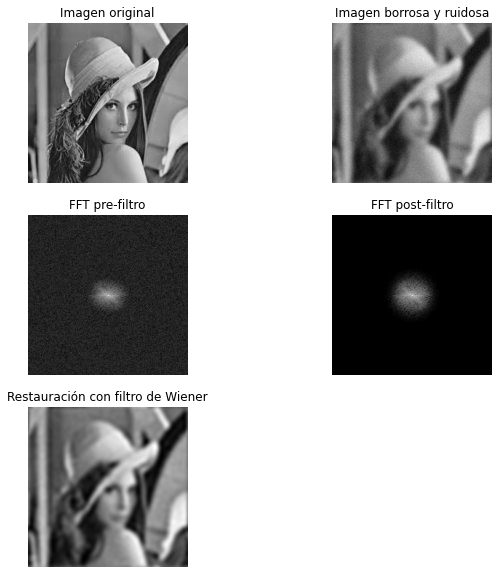

In [69]:
beta=0.90
# calculamos la TF de la imagen borrosa
# y el inverso de la TF del filtro
im_blur_noise_fft = np.fft.fft2(im_blur_noise)
wiener_kernel_fft = beta*kernel_fft.conj()/ ((1-beta)*1 + beta*kernel_fft*kernel_fft.conj()) 


# Los multiplicamos y calculamos la TF inversa
im_restored_fft =wiener_kernel_fft* im_blur_noise_fft
im_restored = np.fft.ifft2(im_restored_fft).real

plt.figure(figsize=(10,10))
plt.gray()
plt.subplot(321), plt.imshow(im), plt.title('Imagen original'), plt.axis('off')
plt.subplot(322), plt.imshow(im_blur_noise), plt.title('Imagen borrosa y ruidosa'), plt.axis('off')
plt.subplot(323), plt.imshow((10*np.log10( 1 + abs(scipy.fft.fftshift(im_blur_noise_fft)))).astype(int),cmap='gray'), plt.title("FFT pre-filtro"), plt.axis('off')
plt.subplot(324), plt.imshow((10*np.log10( 1 + abs(scipy.fft.fftshift(im_restored_fft)))).astype(int),cmap='gray'), plt.title("FFT post-filtro"), plt.axis('off')
plt.subplot(325), plt.imshow(im_restored), plt.title('Restauración con filtro de Wiener')
_=plt.axis('off')

print("Norma de la diferencia de las imágenes",\
      np.linalg.norm(im_restored - im))


El filtro de Wiener tal y como lo hemos visto penaliza a todas las frecuencias por igual. Observa el término $(1-\beta)*1$ en el denominador.

En este ejercicio deberás penalizar más las frecuencias más altas reemplazando el $*1$ en la expresión anterior por 

    *np.fft.fft2(c)*np.fft.fft2(c).conj()

donde c es el filtro paso alto definido por

c(0,0)=1

c(-1,0)=c(1,0)=c(0,1)=c(0,-1)=-1/4

Varía $\beta$ en linspace(0.1, 0.9,9) y para cada uno de los valores de $\beta$ muestra la imagen original, la borrosa y ruidosa y la restauración. ¿Cuál de las restauraciones está más próxima a la imagen original en SNR?

Norma de la diferencia de las imágenes con beta=0.1-> 14.521155191030703
Norma de la diferencia de las imágenes con beta=0.2-> 13.92503200060846
Norma de la diferencia de las imágenes con beta=0.30000000000000004-> 13.594398084869125
Norma de la diferencia de las imágenes con beta=0.4-> 13.371767897637787
Norma de la diferencia de las imágenes con beta=0.5-> 13.211808262472896
Norma de la diferencia de las imágenes con beta=0.6-> 13.100942894223452
Norma de la diferencia de las imágenes con beta=0.7000000000000001-> 13.04750959171757
Norma de la diferencia de las imágenes con beta=0.8-> 13.105420395652887
Norma de la diferencia de las imágenes con beta=0.9-> 13.563782362842765


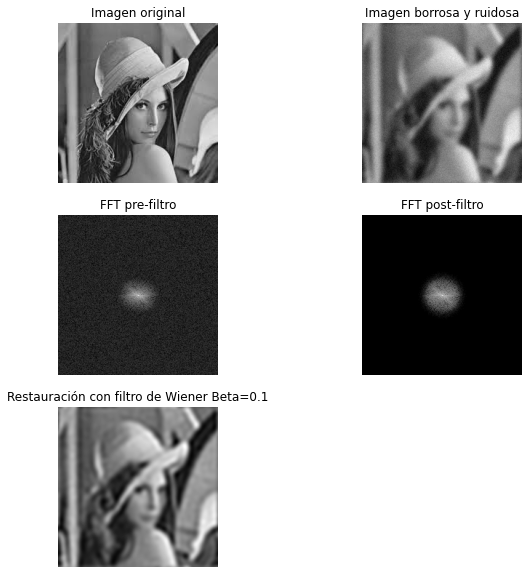

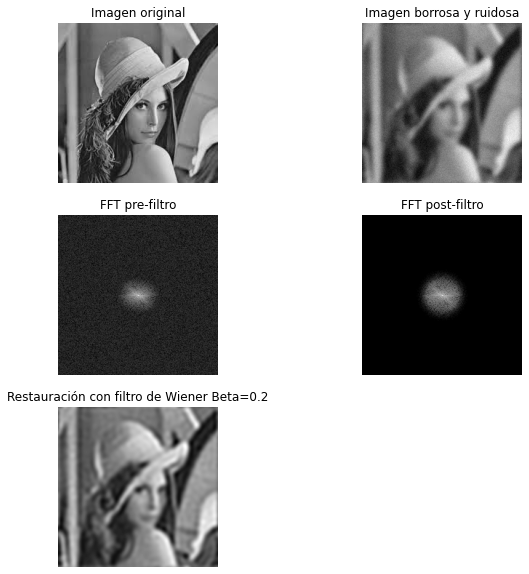

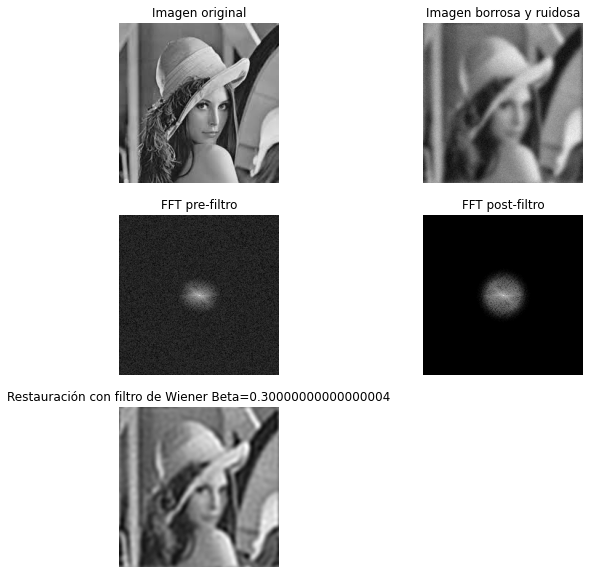

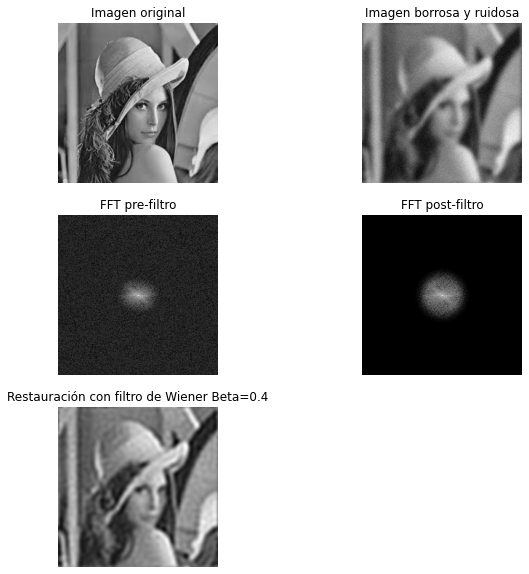

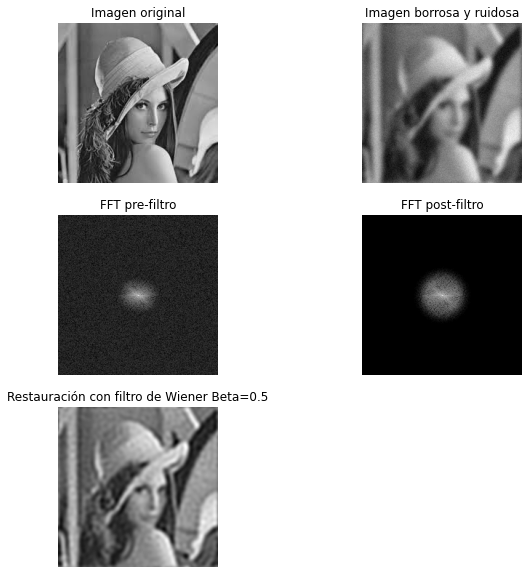

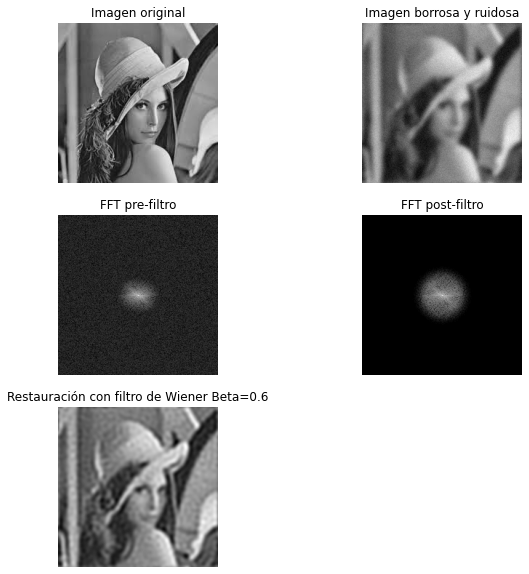

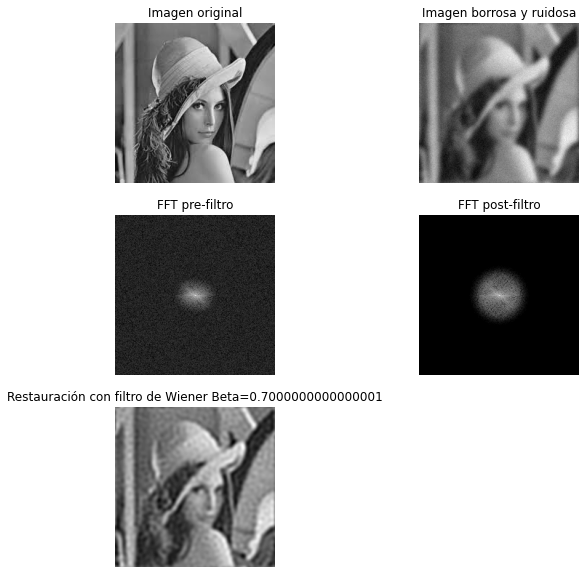

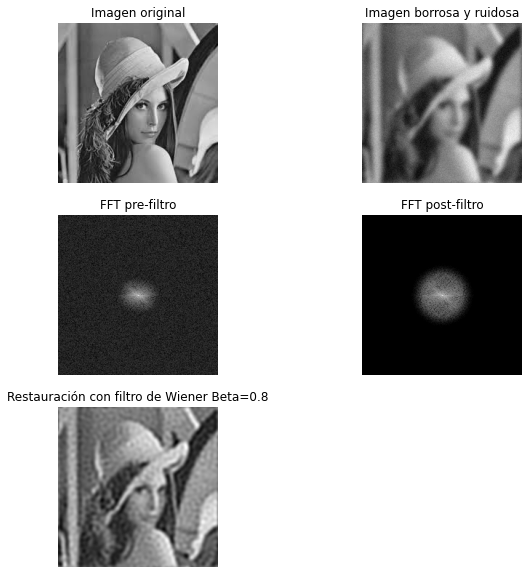

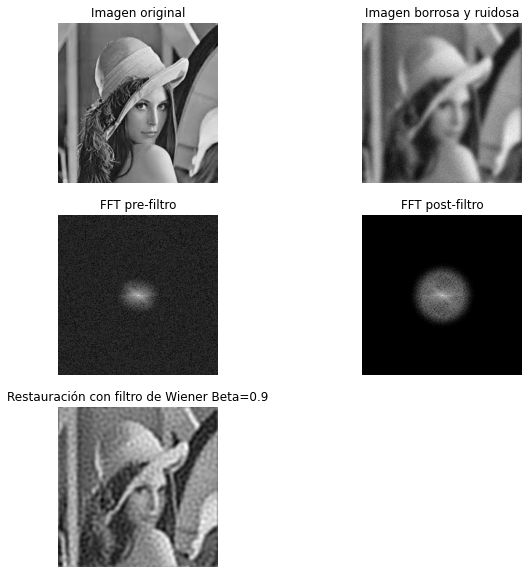

In [78]:
c=np.zeros(im_blur_noise.shape)
c[0,0]=1
c[-1,0]=c[1,0]=c[0,1]=c[0,-1]=-1/4
for beta in np.linspace(0.1, 0.9, 9):
    # calculamos la TF de la imagen borrosa
    # y el inverso de la TF del filtro
    im_blur_noise_fft = np.fft.fft2(im_blur_noise)
    wiener_kernel_fft = beta*kernel_fft.conj()/ ((1-beta)*(np.fft.fft2(c)*np.fft.fft2(c).conj()) + beta*kernel_fft*kernel_fft.conj()) 


    # Los multiplicamos y calculamos la TF inversa
    im_restored_fft =wiener_kernel_fft* im_blur_noise_fft
    im_restored = np.fft.ifft2(im_restored_fft).real

    plt.figure(figsize=(10,10))
    plt.gray()
    plt.subplot(321), plt.imshow(im), plt.title('Imagen original'), plt.axis('off')
    plt.subplot(322), plt.imshow(im_blur_noise), plt.title('Imagen borrosa y ruidosa'), plt.axis('off')
    plt.subplot(323), plt.imshow((10*np.log10( 1 + abs(scipy.fft.fftshift(im_blur_noise_fft)))).astype(int),cmap='gray'), plt.title("FFT pre-filtro"), plt.axis('off')
    plt.subplot(324), plt.imshow((10*np.log10( 1 + abs(scipy.fft.fftshift(im_restored_fft)))).astype(int),cmap='gray'), plt.title("FFT post-filtro"), plt.axis('off')
    plt.subplot(325), plt.imshow(im_restored), plt.title("Restauración con filtro de Wiener Beta={}".format(beta)), plt.axis('off')
    _=plt.plot()

    print("Norma de la diferencia de las imágenes con beta={}->".format(beta),\
          np.linalg.norm(im_restored - im))


¿Cómo justificarías la utilización de este filtro paso alto?

Al utilizar un filtro de paso alto mejoramos los bordes de la imagen por lo que el resultado final es algo más nitido que al usar símplemente el filtro Wiener.
Además podemos observar que el mejor resultado es el que obtenemos con beta=0.7 (13.04750959171757) basándonos en la norma de la diferencia, que es significativamente menor que si no usamos el filtro de paso alto (18.922856242776195).